In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [3]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [30]:
print("Size of users :", np.max(orders.user_id))
orders.head(11)

Size of users : 206209


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000
5,3367565,1,prior,6,2,7,19.000
6,550135,1,prior,7,1,9,20.000
7,3108588,1,prior,8,1,14,14.000
8,2295261,1,prior,9,1,16,0.000
9,2550362,1,prior,10,4,8,30.000


In [5]:
print("Size of Products :", products.shape[0])
print("Size of Aisles :", aisles.shape[0])
print("Size of Departments :", departments.shape[0])
products.head()

Size of Products : 49688
Size of Aisles : 134
Size of Departments : 21


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate("count").reset_index()
print("Size of Users :", cnt_srs.shape[0])

Size of Users : 206209


In [7]:
_mt = pd.merge(order_products_prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt = mt.sort(columns = ["order_id", "add_to_cart_order"], axis = 0, ascending = True)
mt = mt.reset_index(drop = True)
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.000,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.000,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.000,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.000,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.000,baking ingredients
5,2,17794,6,1,Carrots,83,4,202279,prior,3,5,9,8.000,fresh vegetables
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,202279,prior,3,5,9,8.000,doughs gelatins bake mixes
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,202279,prior,3,5,9,8.000,spreads
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,202279,prior,3,5,9,8.000,packaged vegetables fruits
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,205970,prior,16,5,17,12.000,yogurt


In [8]:
mt.order_dow.value_counts()

0    6209666
1    5665856
6    4500304
2    4217798
5    4209533
3    3844117
4    3787215
Name: order_dow, dtype: int64

In [9]:
### cross table of users and aisles
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [10]:
### PCA
from sklearn.decomposition import PCA

def fun_pca(df, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(df)
    pca_samples = pca.transform(df)
    ps = pd.DataFrame(pca_samples)
    print(ps.head())
    return ps

In [11]:
ps = fun_pca(cust_prod, 6)

        0      1       2      3      4      5
0 -24.216  2.429  -2.466 -0.146  0.269 -1.432
1   6.463 36.751   8.383 15.098 -6.921 -0.978
2  -7.990  2.404 -11.030  0.672 -0.442 -2.823
3 -27.991 -0.756  -1.922  2.092 -0.288  0.926
4 -19.896 -2.637   0.533  3.679  0.613 -1.624


In [12]:
### select tow columns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

def plot_pca(df, dim1, dim2):
    tocluster = pd.DataFrame(df[[dim1,dim2]])
    print ("Shape of tocluster", tocluster.shape)
    print (tocluster.head())

    fig = plt.figure(figsize=(8,8))
    plt.plot(tocluster[dim1], tocluster[dim2], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

    plt.xlabel('x_values')
    plt.ylabel('y_values')
    plt.legend()
    plt.show()
    return tocluster

Shape of tocluster (206209, 2)
       4      1
0  0.269  2.429
1 -6.921 36.751
2 -0.442  2.404
3 -0.288 -0.756
4  0.613 -2.637


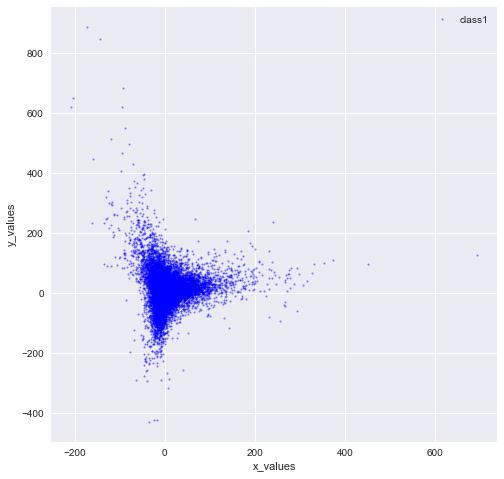

In [13]:
tocluster = plot_pca(df=ps, dim1=4, dim2=1)

In [14]:
### kmeans, "k = 4"
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib

def fun_kmeans(df, n_clusters):
    clusterer = KMeans(n_clusters = 4,random_state = 42).fit(df)
    centers = clusterer.cluster_centers_
    print(centers)
    c_preds = clusterer.predict(df)
    
    ### scatter plot to see the result
    fig = plt.figure(figsize=(8,8))
    colors = ['orange','blue','purple','green']
    colored = [colors[k] for k in c_preds]
    plt.scatter(df.iloc[:, [0]],df.iloc[:, [1]],  color = colored)
    for ci,c in enumerate(centers):
        plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

    plt.xlabel('x_values')
    plt.ylabel('y_values')
    plt.legend()
    plt.show()
    return c_preds

[[ -0.11868837   0.09644088]
 [-11.26759642  65.248165  ]
 [ -4.71388584 -40.63421033]
 [ 76.82338698  26.26358548]]


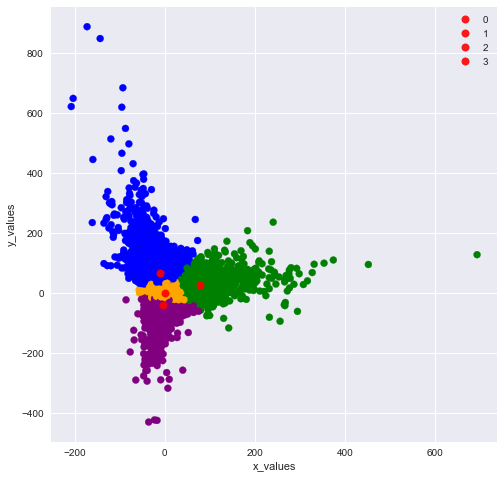

In [15]:
c_preds = fun_kmeans(tocluster, 4)

In [16]:
### 與cross table結合
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

(206209, 135)


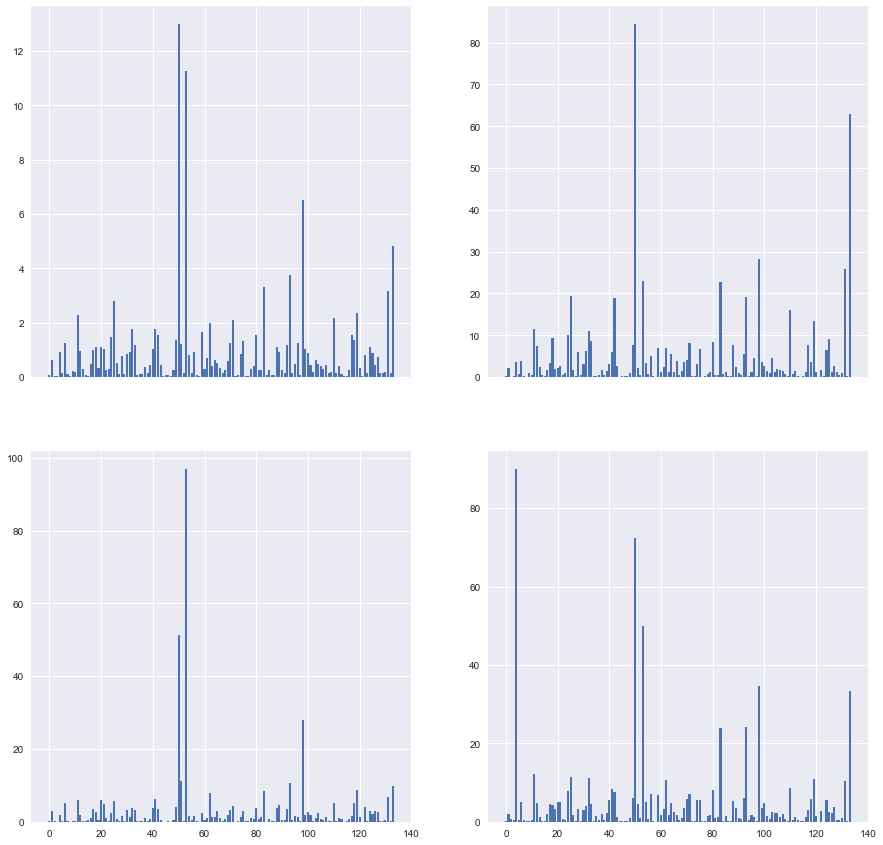

In [17]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

> 畫出每一群裡面每種貨櫃被購買的平均數量。

In [18]:
for i in [c0, c1, c2, c3]:
    print(i.sort_values(ascending=False)[0:15])

aisle
fresh fruits                    12.997
fresh vegetables                11.265
packaged vegetables fruits       6.532
yogurt                           4.839
packaged cheese                  3.755
milk                             3.303
water seltzer sparkling water    3.169
chips pretzels                   2.783
soy lactosefree                  2.350
bread                            2.279
refrigerated                     2.169
ice cream ice                    2.083
frozen produce                   2.001
eggs                             1.778
crackers                         1.766
dtype: float64
aisle
fresh fruits                    84.445
yogurt                          62.985
packaged vegetables fruits      28.129
water seltzer sparkling water   25.796
fresh vegetables                22.892
milk                            22.727
chips pretzels                  19.450
packaged cheese                 19.043
energy granola bars             19.022
refrigerated                    16.01

> 我們可以檢查在這些貨物的數量和比例上，群集是否不同，或者一個群集的特徵是沒有列入本清單中的某些商品。  
例如，我們已經可以看到群集3的特點是“嬰兒食品配方”產品，這是其他群集的顯著區別。

In [19]:
### 試試看用購買時間分群
cust_prod_1 = pd.crosstab(mt['user_id'], mt['order_hour_of_day'])
cust_prod_2 = pd.crosstab(mt['user_id'], mt['order_dow'])
cust_prod1 = pd.concat([cust_prod_1, cust_prod_2], axis=1)
cust_prod1.columns = ["hr0","hr1","hr2","hr3","hr4","hr5","hr6","hr7","hr8","hr9","hr10",
                      "hr11","hr12","hr13","hr14","hr15","hr16","hr17","hr18","hr19","hr20",
                      "hr21","hr22","hr23",
                      "sun","mon","tue","wed","thu","fri","sat"]

cust_prod1.head(10)

,hr0,hr1,hr2,hr3,hr4,hr5,hr6,hr7,hr8,hr9,...,hr21,hr22,hr23,sun,mon,tue,wed,thu,fri,sat
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,15,14,5,...,0,0,0,0,17,9,11,22,0,0
2,0,0,0,0,0,0,0,0,0,66,...,0,0,0,0,64,87,29,9,6,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,46,16,5,21,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,5,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,12,0,16,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,7,4,0
7,0,0,0,0,0,0,0,10,0,37,...,0,0,0,78,36,24,39,0,19,10
8,34,0,0,0,0,0,0,0,15,0,...,0,0,0,0,15,0,0,0,13,21
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,11,30,0,0,0,35,0


        0       1
0 -47.153 -18.069
1  25.040 -74.097
2 -29.315  19.986
3 -64.755  -2.950
4 -55.641  -3.140
Shape of tocluster (206209, 2)
        0       1
0 -47.153 -18.069
1  25.040 -74.097
2 -29.315  19.986
3 -64.755  -2.950
4 -55.641  -3.140


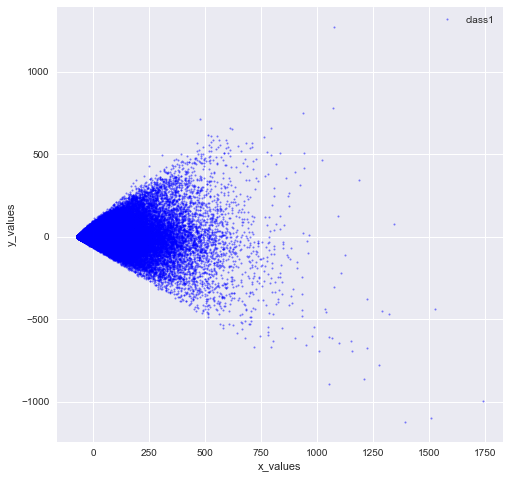

In [25]:
ps1 = fun_pca(cust_prod1, 2)
tocluster1 = plot_pca(df=ps1, dim1=0, dim2=1)

[[  76.23944727   -0.42004866]
 [ -40.02604298   -1.06296722]
 [ 265.93095361  142.81586478]
 [ 342.09570571 -112.5028591 ]]


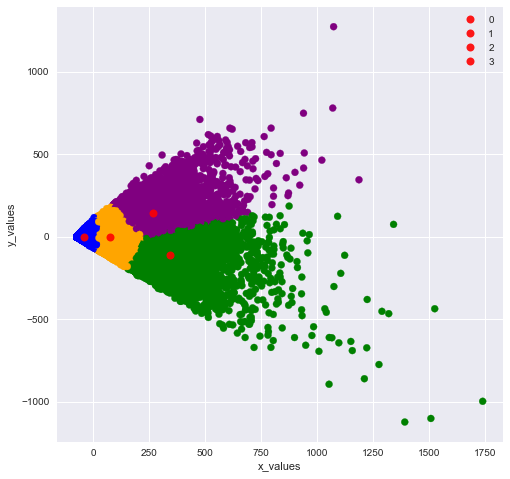

In [26]:
c_preds1 = fun_kmeans(tocluster1, 4)

In [27]:
### 與cross table結合
clust_prod = cust_prod1.copy()
clust_prod['cluster'] = c_preds1
clust_prod.head()

,hr0,hr1,hr2,hr3,hr4,hr5,hr6,hr7,hr8,hr9,...,hr22,hr23,sun,mon,tue,wed,thu,fri,sat,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,15,14,5,...,0,0,0,17,9,11,22,0,0,1
2,0,0,0,0,0,0,0,0,0,66,...,0,0,0,64,87,29,9,6,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,46,16,5,21,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,5,4,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,9,12,0,16,0,0,0,1


(206209, 32)


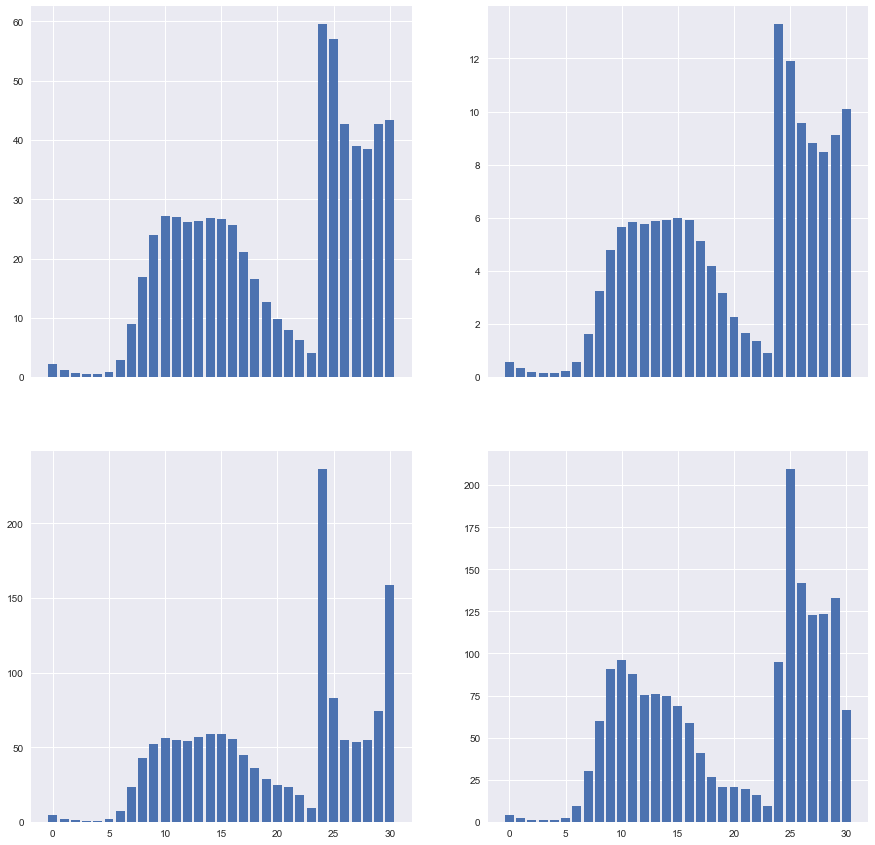

In [28]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()